In [1]:
import os
from typing import Any

from pydantic import BaseModel
from unstructured.partition.pdf import partition_pdf
import json
# import tesseract
import pytesseract
from typing import *
from box import ConfigBox
from pathlib import Path
import re, sys, os
from functools import partial



import io
import os
import base64
import numpy as np
from PIL import Image
from langchain.chat_models import ChatOpenAI
from langchain.schema.messages import HumanMessage, SystemMessage, AIMessage


import uuid
from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain.schema.document import Document
from langchain.embeddings import OpenAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever

from dotenv import load_dotenv

from dataclasses import dataclass

/Users/goldyrana/miniconda3/envs/bounce/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv()

True

In [3]:
from backend.src.utils.common import *
from backend.logger import logger
from backend.src.constants import *


In [4]:
os.getcwd()
os.chdir("../../")

In [5]:
%load_ext watermark
%watermark -a "Rajesh goldy" -vmp langchain,unstructured,openai,pydantic,pytesseract

Author: Rajesh goldy

Python implementation: CPython
Python version       : 3.9.21
IPython version      : 8.18.1

langchain   : 0.3.17
unstructured: 0.16.11
openai      : 1.61.1
pydantic    : 2.10.6
pytesseract : 0.3.13

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 24.1.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit



In [6]:
class Extractor:
    def __init__(self):
        pass
    
    def get_metadata(raw_pdf_element: List) -> List:
        """To get the metadata of elements

        Args:
            raw_pdf_element (List): list of elements in pdf

        Returns:
            List: containing meta data
        """
        metadata = []
        for element in raw_pdf_element:
            metadata.append(element.metadata.to_dict())
        
        return metadata
    
    def add_metadata(self, element, **kwargs):
        metadata = kwargs
        return Document(element, metadata)
 
    def get_year(self, file: str) -> str:
        """To get the year from file name
        Args:
            file: name of with extension"""
        
        year = re.search(r"\d{4}", file).group()    
        if year:
            return str(year)
        else:
            try:
                file_name = os.path.split(file)[-1].split(".")[0]
                return file_name
            except Exception as e:
                logger.error(f"Error in getting year from file: {file} with error: {e}")
                return "1.0"
        
    def extract_data(self, pdf_file, **kwargs):
        raw_pdf_elements = partition_pdf(filename=pdf_file, **kwargs)
        return raw_pdf_elements
    
    def generate_unique_id(self, data: Iterator)-> List[str]:
        """To generate unique id for each element"""
        
        unique_id = []
        for _ in data:
            unique_id.append(str(uuid.uuid4()))
        
        return unique_id
    
    def generate_document(self, content: List, id_key: str):
        """To generate document from content"""
                
        ids = self.generate_unique_id(content)
        summaries = [Document(page_content=summary, metadata={id_key: ids[index]})
                         for index, summary in enumerate(content)]
        
        return summaries
    
    @staticmethod
    def seprate_data_metadata(data: List[dict], text_name: str="text", metadata_name: str="metadata") -> Tuple[List, List]:
        """To seprate data and metadata from dict

        Args:
            data (List[dict]): List containing dict >> text with metadata
            text_name (str): key to get text from dict. Defaults to "text"
            metadata_name (str): key to get metadata from dict. Defaults to "metadata"

        Returns:
            Tuple: containing text, metadata
        """
        text, metadata = [], []
        for i in data:
            text.append(i[text_name])
            metadata.append(i[metadata_name])
        return text, metadata
        

In [7]:
from unstructured.documents.elements import CompositeElement, Table, Image, ListItem  # Import ListItem
from unstructured.documents.elements import CompositeElement, Table, Image, ListItem  # Import ListItem



@dataclass
class DataIngestionConfig:
    raw: str # raw pdf path
    reports: str # processed reports path
    metadata: list # metadata to collect from raw_pdf_elements
    
    
class ConfigurationManager:
    def __init__(self, CONFIG_FILE_PATH, PARAMS_FILE_PATH):
        self.config = read_yaml(CONFIG_FILE_PATH)
        self.params = read_yaml(PARAMS_FILE_PATH)
        
    def get_data_ingestion_params(self) -> DataIngestionConfig:
        params = DataIngestionConfig(
            raw=self.config.data_dir.raw,
            reports=self.config.data_dir.reports,
            metadata=self.config.metadata)
        return params
    
    
class DataIngestion(Extractor):
    def __init__(self, config):
        super(DataIngestion, self).__init__()
        self.config = config
        self.raw_pdf_elements = None
        self.current_pdf_file = None # to keep track of current pdf file being processed (future case)
    
    # def data_with_metadata(self, raw_pdf_elements: List) -> Tuple[List]:
    #     """To get the data with metadata from raw_pdf_elements

    #     Args:
    #         raw_pdf_elements (List): list of elements returned by partition_pdf

    #     Returns:
    #         tuple: containing text_elements, table_elements, list_items
    #     """
    #     text_elements = []
    #     table_elements = []
    #     list_items = []
    #     # add new structure here 
        
    #     for element in raw_pdf_elements:
    #         metadata = element.metadata.to_dict() if element.metadata else {}

    #         # Store text with metadata
    #         if isinstance(element, CompositeElement):
    #             text_elements.append({
    #                 "text": str(element),
    #                 "metadata": metadata
    #             })
    #         # Store tables with metadata
    #         elif isinstance(element, Table):
    #             table_elements.append({
    #                 "table": str(element),
    #                 "metadata": metadata
    #             })
    #         # Store ListItem with metadata
    #         elif isinstance(element, ListItem):
    #             list_items.append({
    #                 "list_item": str(element),
    #                 "metadata": metadata
    #             })
                
    #     return (text_elements, table_elements, list_items)
    
    def process_pdf(self, pdf_file_path: str, **kwargs):  
        """To extract the data from pdf file using unstructured library
            Args:
                pdf_file_path (str): full path of pdf file

            Returns:
                configBox: Box containing text_elements, table_elements, list_items
        """
        
        file_name = os.path.split(pdf_file_path)[-1].split(".")[0] # get the filename from file name and set it as directory name
        report_dir = os.path.join(self.config.reports, file_name) 
        create_directory(report_dir, is_extension_present=False) # create directory with file_name
        if kwargs.get("extract_image_block_output_dir", None) == None: # to create image folder in report_dir
            kwargs["extract_image_block_output_dir"] = os.path.join(report_dir, "images")
            
        raw_pdf_elements = self.extract_data(pdf_file_path, **kwargs)
        
        return raw_pdf_elements, report_dir
        

In [8]:
config_manager = ConfigurationManager(CONFIG_FILE_PATH, PARAMS_FILE_PATH)
data_extractor_config = config_manager.get_data_ingestion_params()

data_extractor = DataIngestion(data_extractor_config)

2025-02-09 15:28:00,686 - root - INFO - Yaml read successfully from config.yaml
2025-02-09 15:28:00,688 - root - ERROR - FileNotFoundError: params.yaml


In [9]:
current_pdf_dir = "backend/data/reports/2023_removed"

In [17]:
data, current_pdf_dir = data_extractor.process_pdf(pdf_file_path="backend/data/raw_pdfs/2023_removed.pdf",
                                  save=True,
                                    strategy="hi_res", # 
                                    split_pdf_page=True,  # to process each page seprately
                                    split_pdf_allow_failed=True, # continue processing even if some pages fail
                                    extract_images_in_pdf=True,
                                    infer_table_structure=True,
                                    chunking_strategy="by_title",
                                    extract_image_block_types = ["Image" , "Table"],
                                    max_characters=4000,
                                    new_after_n_chars=3800,
                                    combine_text_under_n_chars=2000
                                    )


2025-02-09 13:46:20,620 - root - INFO - Creating directory at backend/data/reports/2023_removed
2025-02-09 13:46:21,098 - pikepdf._core - INFO - pikepdf C++ to Python logger bridge initialized
2025-02-09 13:46:21,632 - pdfminer.psparser - DEBUG - seek: 0
2025-02-09 13:46:21,661 - pdfminer.pdfdocument - DEBUG - find_xref: b''
2025-02-09 13:46:21,663 - pdfminer.pdfdocument - DEBUG - find_xref: b'%%EOF'
2025-02-09 13:46:21,664 - pdfminer.pdfdocument - DEBUG - find_xref: b'10081360'
2025-02-09 13:46:21,665 - pdfminer.pdfdocument - DEBUG - find_xref: b'startxref'
2025-02-09 13:46:21,666 - pdfminer.pdfdocument - DEBUG - xref found: pos=b'10081360'
2025-02-09 13:46:21,667 - pdfminer.psparser - DEBUG - seek: 10081360
2025-02-09 13:46:21,670 - pdfminer.psparser - DEBUG - nexttoken: (10081360, /b'xref')
2025-02-09 13:46:21,671 - pdfminer.pdfdocument - DEBUG - read_xref_from: start=10081360, token=/b'xref'
2025-02-09 13:46:21,671 - pdfminer.psparser - DEBUG - nextline: 10081364, b'\n'
2025-02-09 

# Image Summarizer

In [10]:
@dataclass
class ImageSummarizerConfig:
    model: str # name of model
    image_summary_dir: str # image summaries directory
    summarizer_prompt_dir: str
    
class ConfigurationManager:
    def __init__(self, CONFIG_FILE_PATH, PARAMS_FILE_PATH):
        self.config = read_yaml(CONFIG_FILE_PATH)
        self.params = read_yaml(PARAMS_FILE_PATH)
        
    def get_image_summarizer_params(self) -> ImageSummarizerConfig:
        params = ImageSummarizerConfig(
            model=self.config.model.chat_model,
            image_summary_dir=self.config.image_summarizer.image_summary_dir,
            summarizer_prompt_dir=self.config.prompts.summarizer_prompt_dir)
        return params
    
class ImageSummarizer(Extractor, ):
    def __init__(self, config, model: object):
        super().__init__()
        self.config = config
        self.model = model
        self.image_summary_prompt = read_json(self.config.summarizer_prompt_dir)["image_summarizer_prompt"]
        
        # automatic metadata
        self.image_path = None
        self.type = "Image"
        self.uuids = None
        
    def encode_image(self, image_path):
        """Encode image to base64
        Args:
            image_path: path to image
        Returns:
            str: base64 encoded image"""
        try:
            with open(image_path, "rb") as image:
                return base64.b64encode(image.read()).decode("utf-8")
        except Exception as e:
            print(f"Error: {e}")
            raise e
        
    def image_summarize(self, img_base64) -> str:
        """Summarize image using LLM model API
        Args:
            img_base64: base64 encoded image
            prompt: prompt to summarize image
        Returns:
            str: summary of image"""
        
        msg = self.model.invoke(
            [
                HumanMessage(
                    content=[
                        {"type": "text", "text": self.image_summary_prompt},
                        {
                            "type": "image_url",
                            "image_url": {
                                "url": f"data:image/jpeg;base64,{img_base64}"
                            },
                        },
                    ]
                )
            ]
        )
        return msg.content

    def get_image_path(self, path: str):
        """Returns the images path by joining the main path and the image names

        Args:
            path (str): image folder

        Returns:
            list[str]: containing images path 
        """
        # automatic metadata
        self.image_path = path
        
        x = os.listdir(path)
        images_path = []
        for image in x:
            images_path.append(os.path.join(path, image))
        return images_path
    
    @staticmethod
    def create_doc_from_list(data: List) -> List:
        """To create document from list of data"""
        _ = []
        
        for metadata, doc in data:
            metadata = {"doc_id": metadata}
            _.append(Document(doc, metadata=metadata))
        return _
    
    def add_metadata(self, encoded_images, summaries, metadata: dict=None, automatic_metadata=False) -> Tuple[List[tuple], List[Document]]:
        if automatic_metadata:
            self.uuids = [str(uuid.uuid4()) for i in encoded_images]

            metadata = {"source": self.image_path,
                        "type": self.type}
                    
        encoded_images_with_metadata = list(zip(self.uuids, encoded_images))
        
        summaries_with_metadata = []
        for index, summary in enumerate(summaries):
            metadata["doc_id"] = self.uuids[index]
            summaries_with_metadata.append(Document(page_content=summary, metadata=metadata))
            
        return encoded_images_with_metadata, summaries_with_metadata
        
            
            
        
    

In [13]:
model = ChatOpenAI(temperature=0, model="gpt-4o")
config_manager = ConfigurationManager(CONFIG_FILE_PATH, PARAMS_FILE_PATH)
image_summarizer_config = config_manager.get_image_summarizer_params()
image_summarizer = ImageSummarizer(image_summarizer_config, model)

2025-02-09 15:38:42,326 - root - INFO - Yaml read successfully from config.yaml
2025-02-09 15:38:42,327 - root - ERROR - FileNotFoundError: params.yaml
2025-02-09 15:38:42,329 - root - INFO - Json object read sucessfully 


2025-02-09 15:38:42,496 - openai._base_client - DEBUG - Request options: {'method': 'post', 'url': '/chat/completions', 'files': None, 'json_data': {'messages': [{'role': 'user', 'content': [{'type': 'text', 'text': 'Describe the image in detail. Be specific about graphs and numbers'}, {'type': 'image_url', 'image_url': {'url': ''}}]}], 'model': 'gpt-4o', 'n': 1, 'stream': False, 'temperature': 0.0}}
2025-02-09 15:38:42,498 - openai._base_client - DEBUG - Sending HTTP Request: POST https://api.openai.com/v1/chat/completions
2025-02-09 15:38:42,504 - httpcore.connection - DEBUG - connect_tcp.started host='api.openai.com' port=443 local_address=None timeout=None socket_options=None

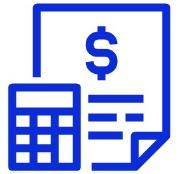

2025-02-09 15:38:42,537 - httpcore.connection - DEBUG - connect_tcp.complete return_value=<httpcore._backends.sync.SyncStream object at 0x1711e5d60>
2025-02-09 15:38:42,540 - httpcore.connection - DEBUG - start_tls.started ssl_context=<ssl.SSLContext object at 0x339d41f40> server_hostname='api.openai.com' timeout=None
2025-02-09 15:38:42,560 - httpcore.connection - DEBUG - start_tls.complete return_value=<httpcore._backends.sync.SyncStream object at 0x1711e5550>
2025-02-09 15:38:42,561 - httpcore.http11 - DEBUG - send_request_headers.started request=<Request [b'POST']>
2025-02-09 15:38:42,562 - httpcore.http11 - DEBUG - send_request_headers.complete
2025-02-09 15:38:42,563 - httpcore.http11 - DEBUG - send_request_body.started request=<Request [b'POST']>
2025-02-09 15:38:42,563 - httpcore.http11 - DEBUG - send_request_body.complete
2025-02-09 15:38:42,564 - httpcore.http11 - DEBUG - receive_response_headers.started request=<Request [b'POST']>
2025-02-09 15:38:45,615 - httpcore.http11 - 
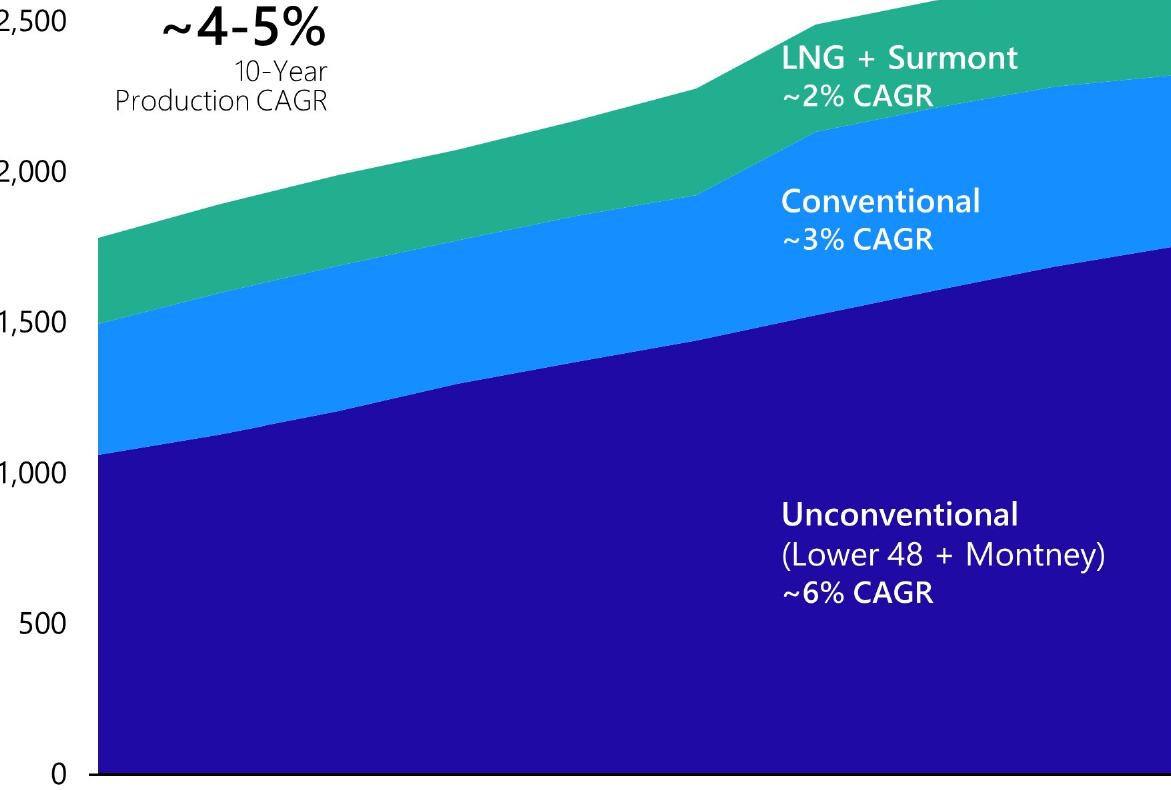
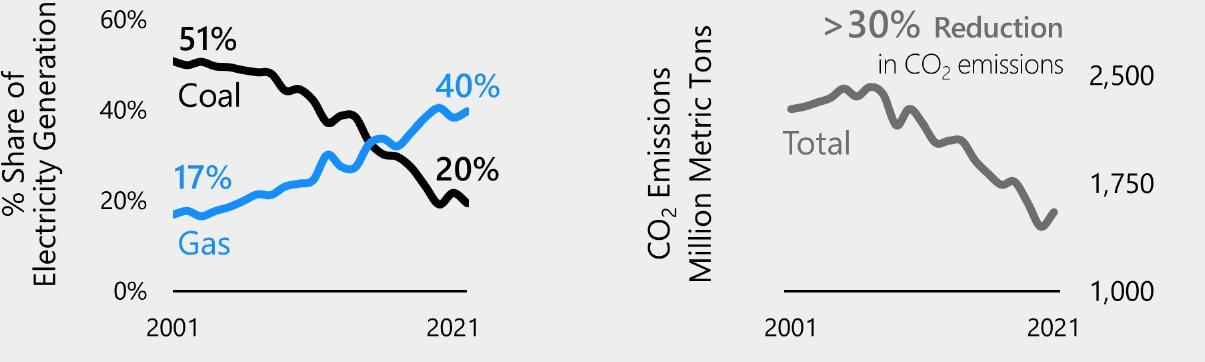
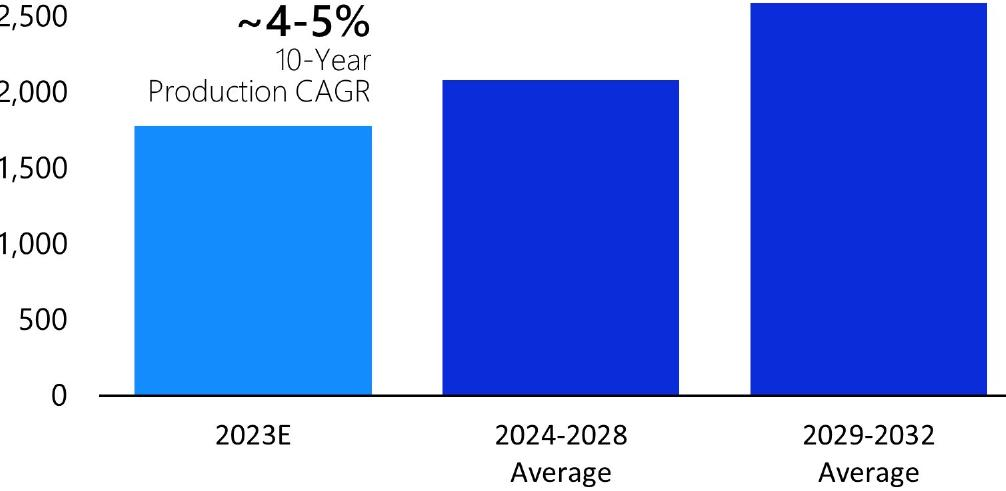
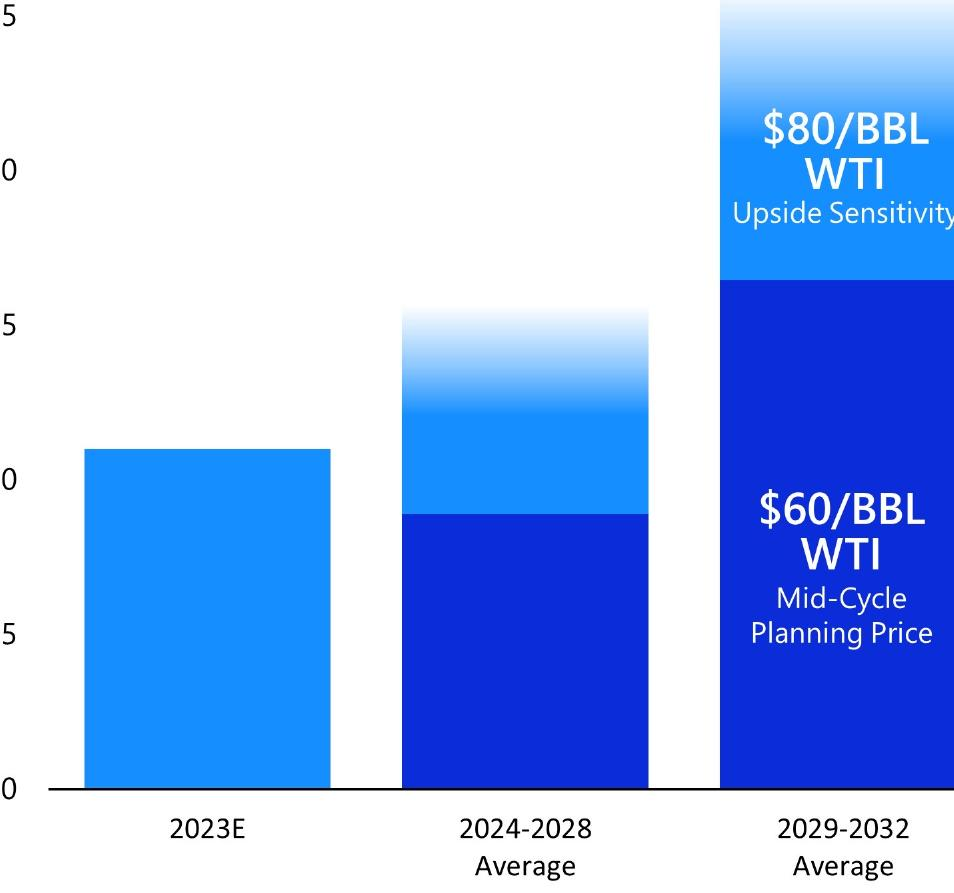
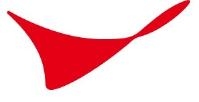
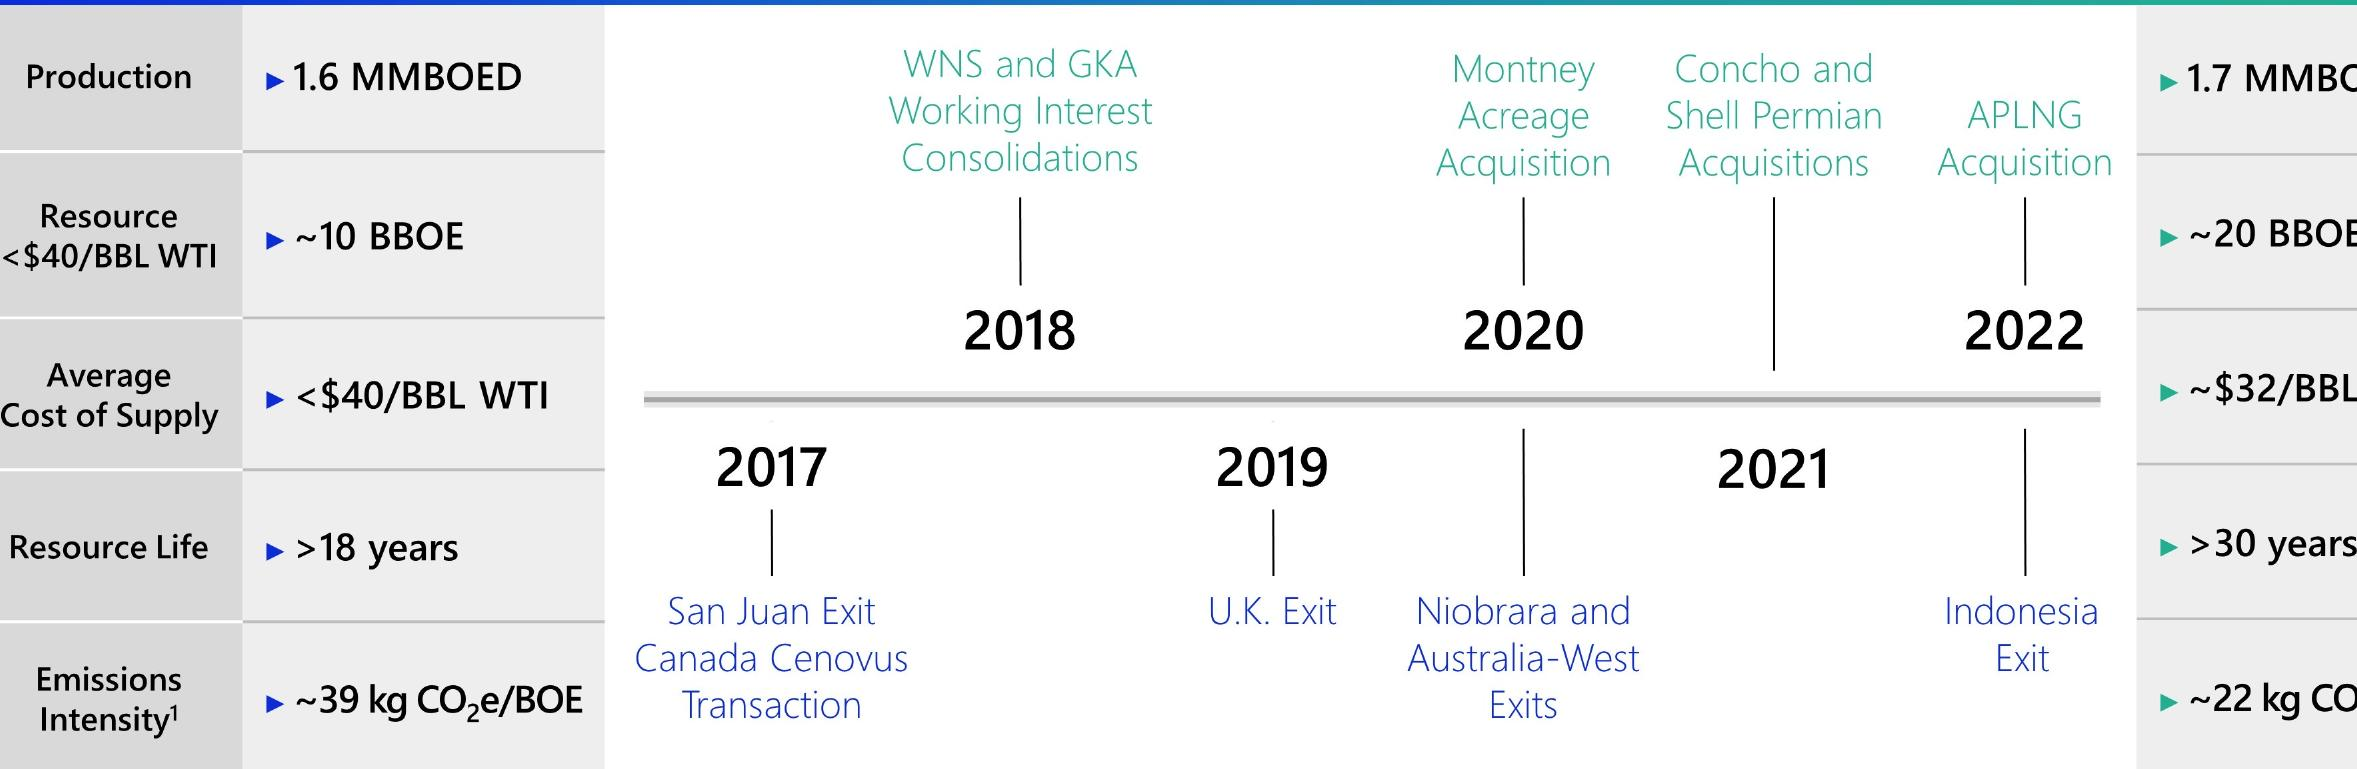
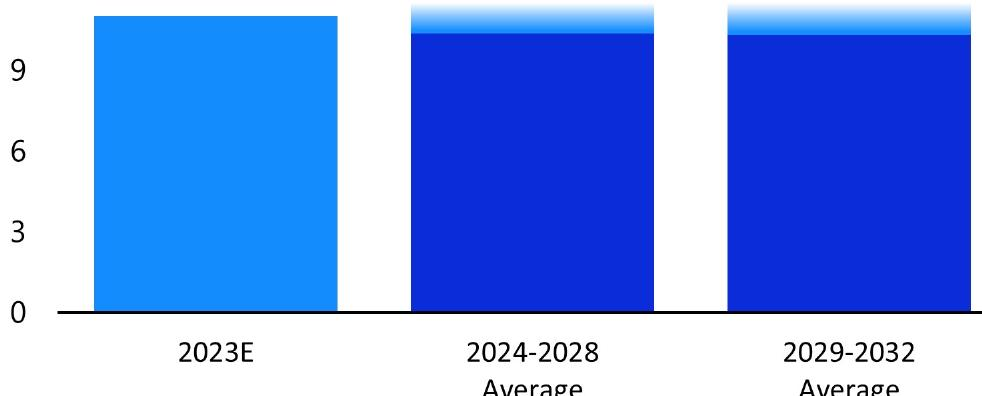
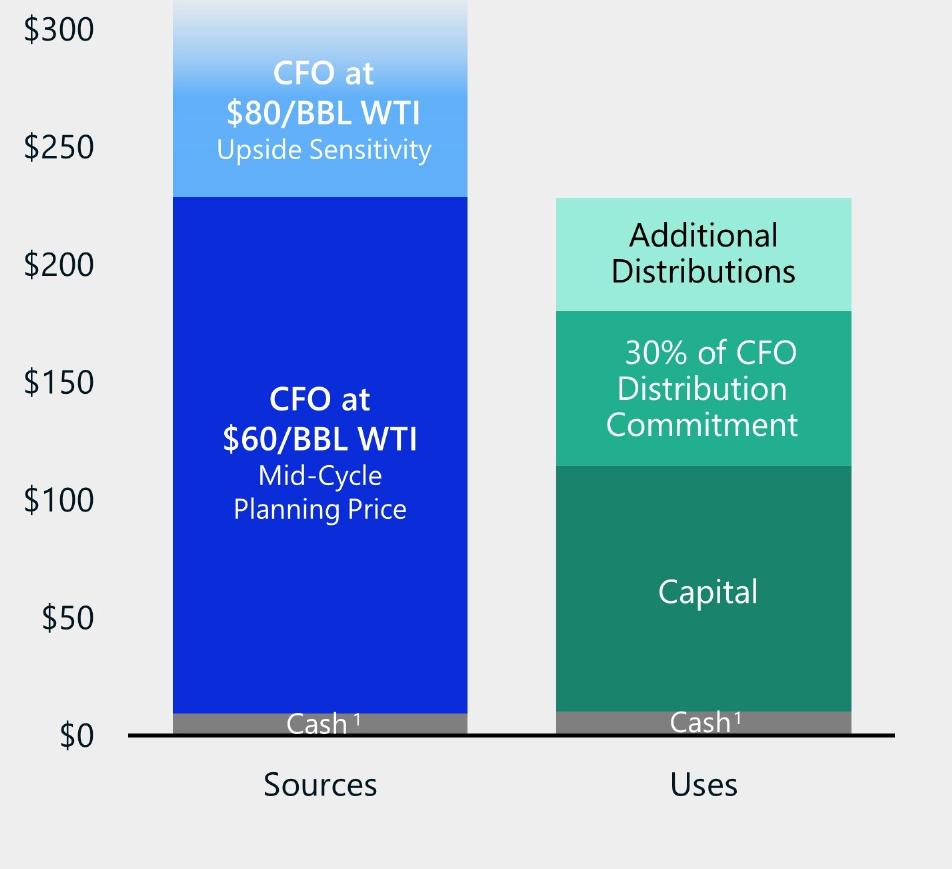
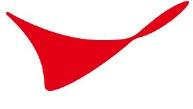
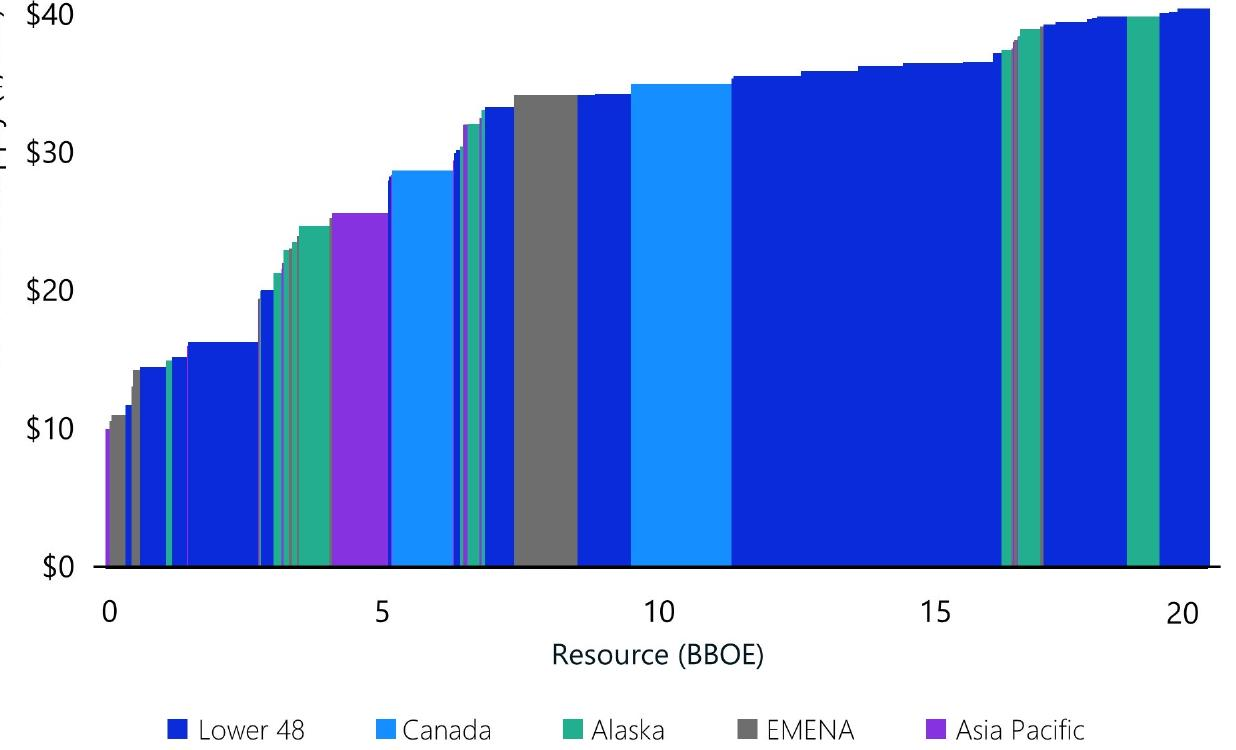
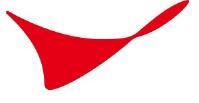
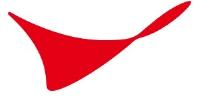
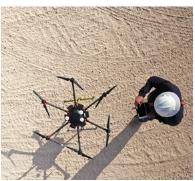
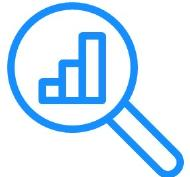
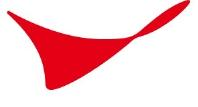
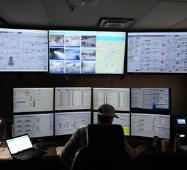
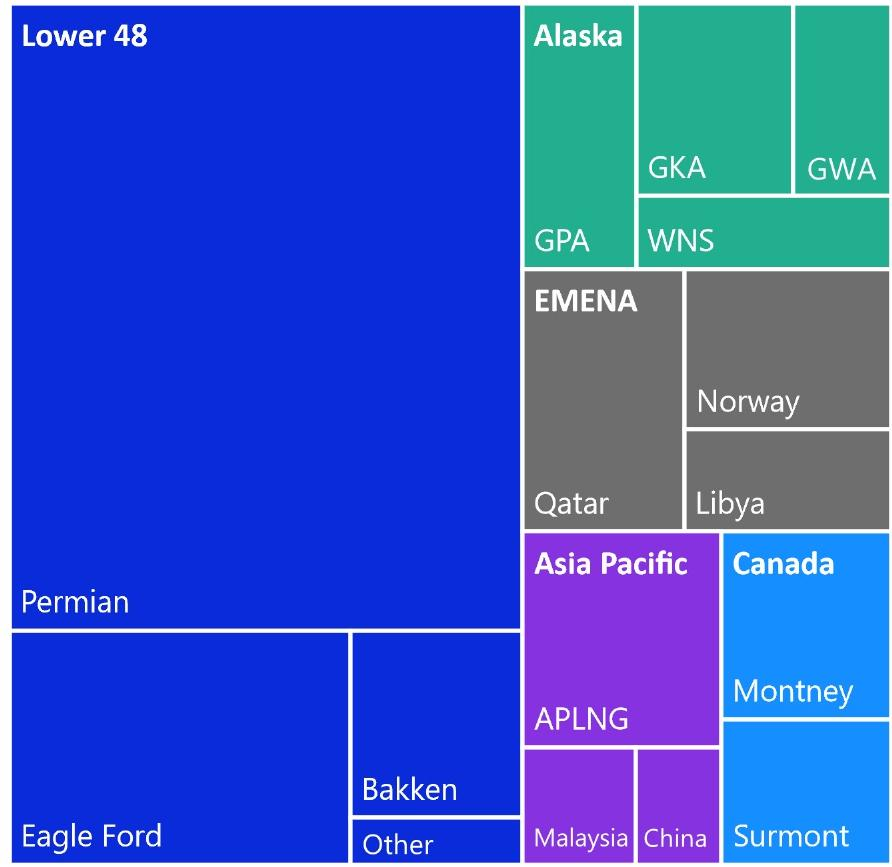
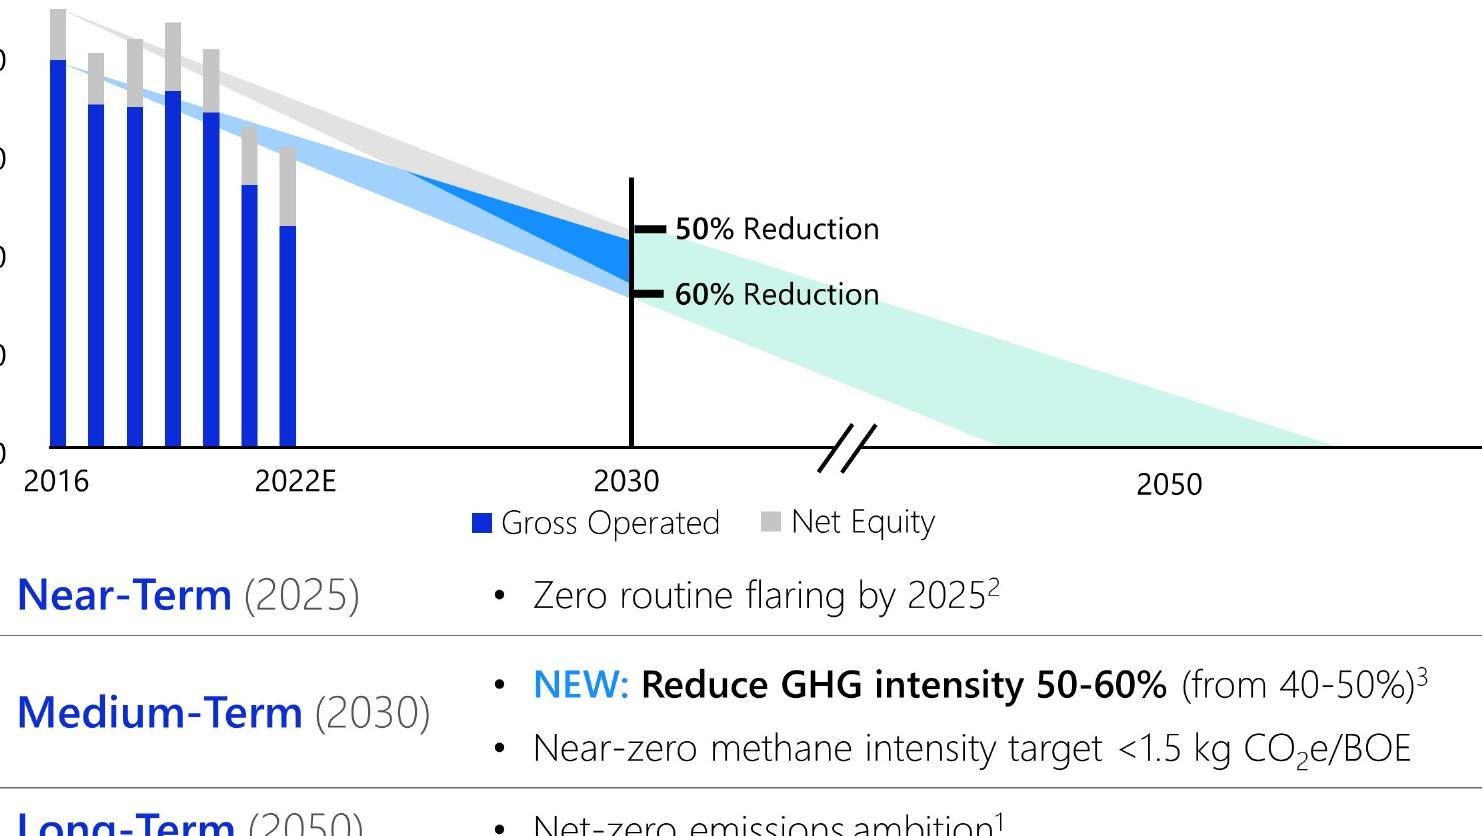
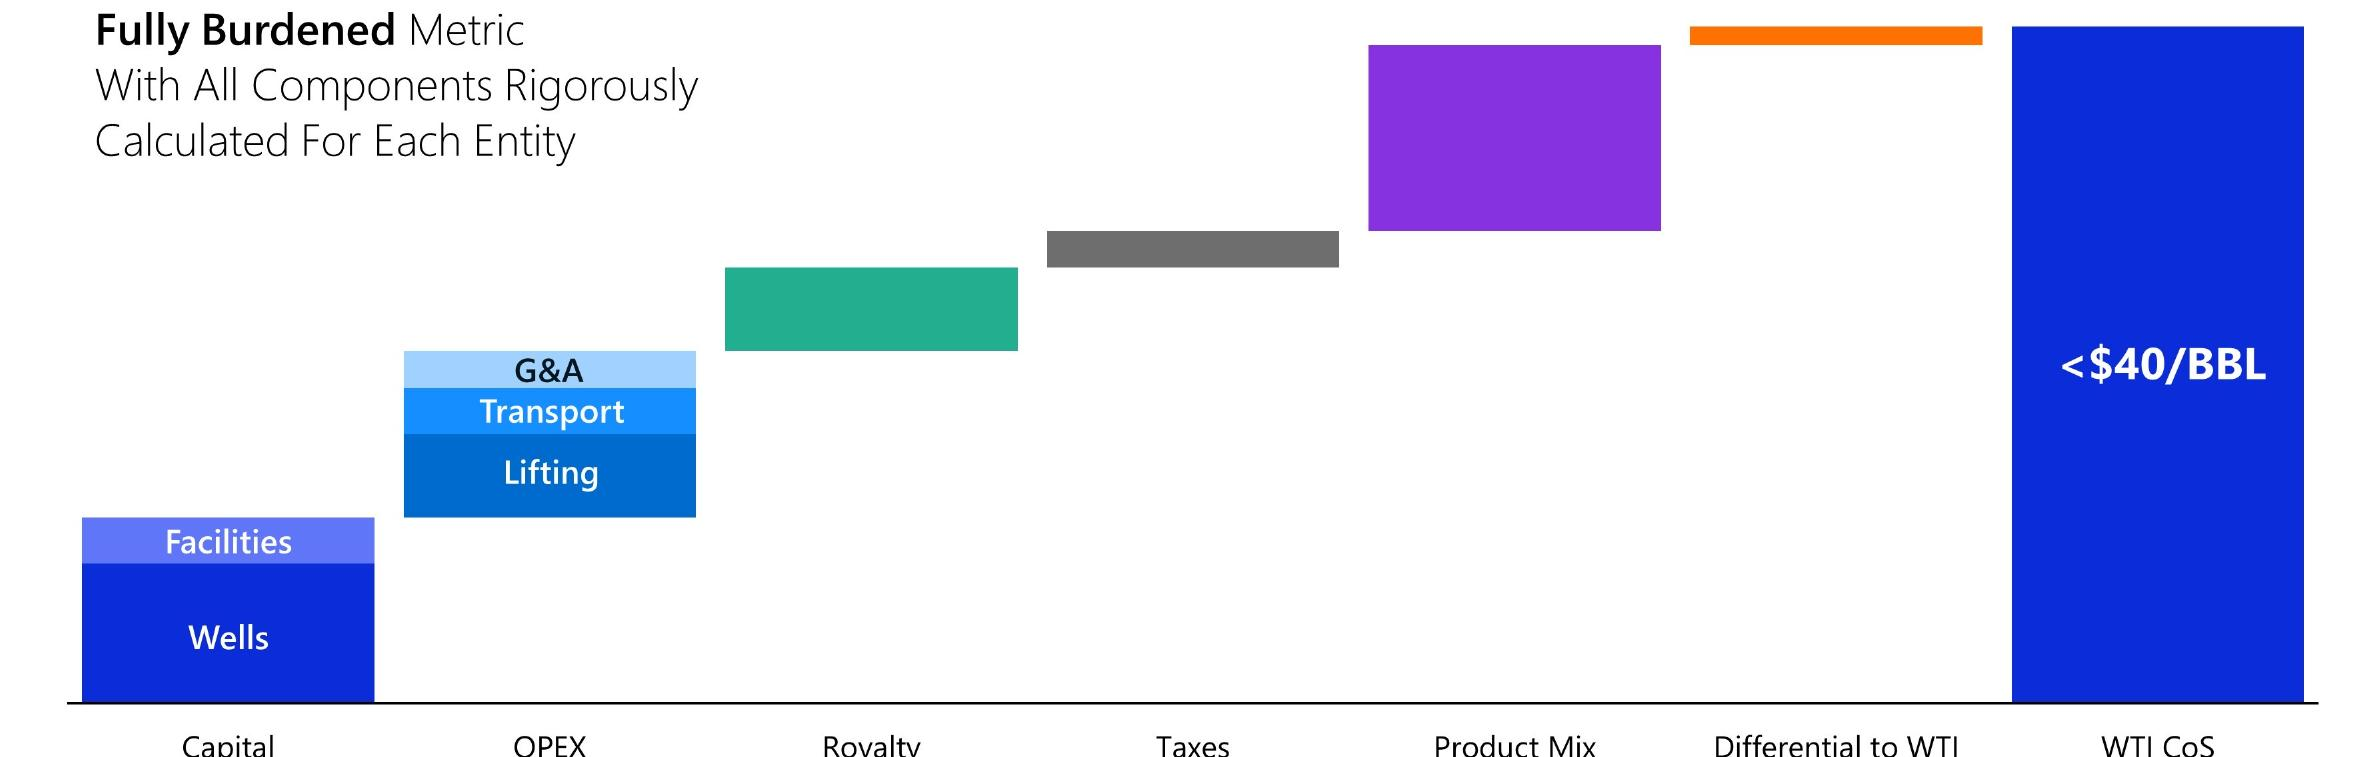
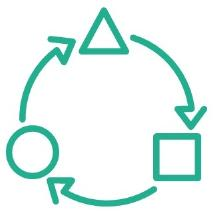
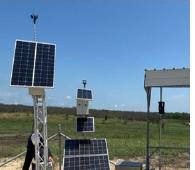
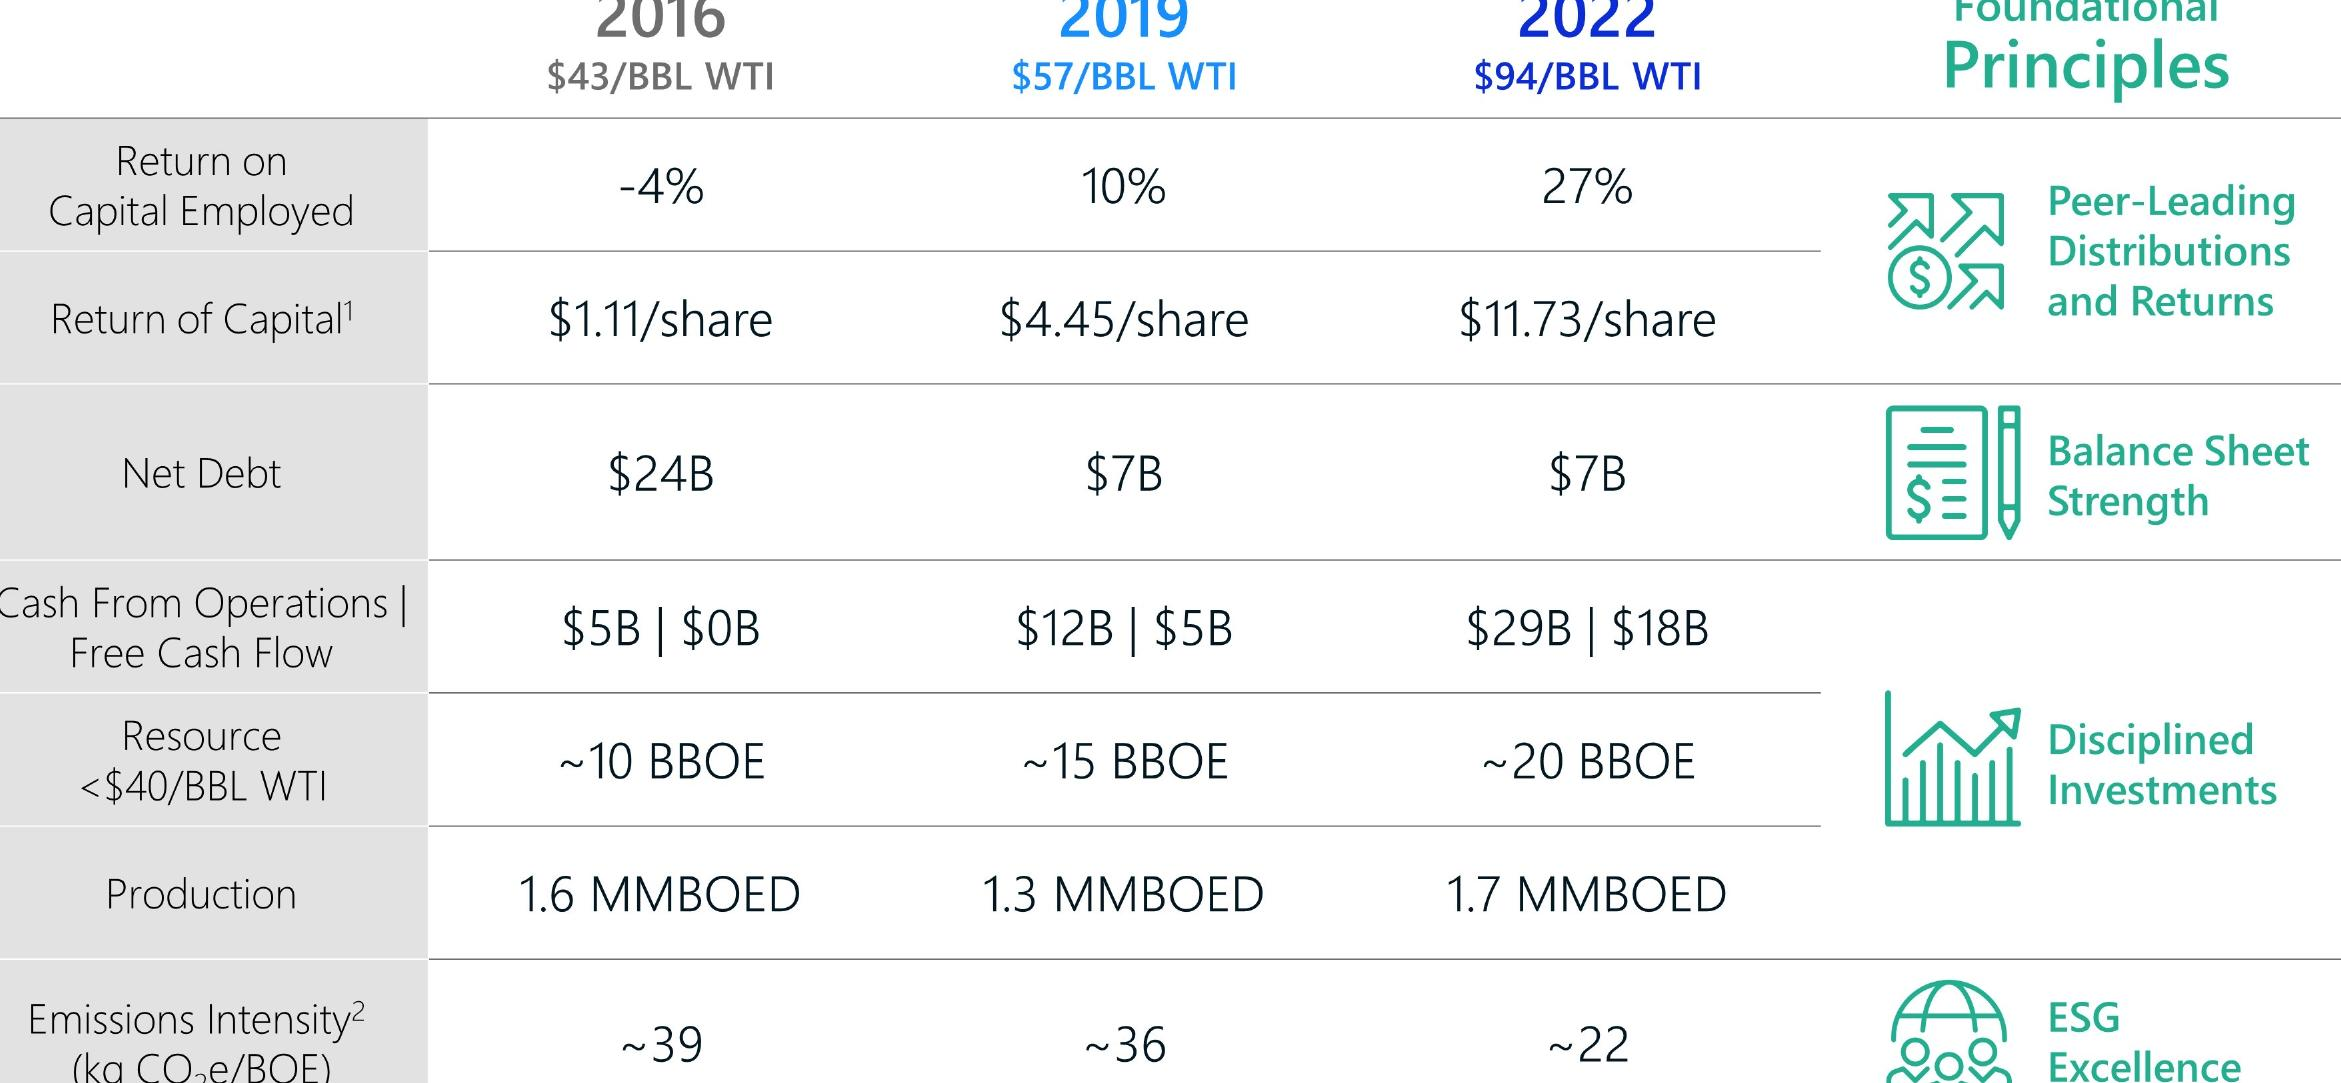
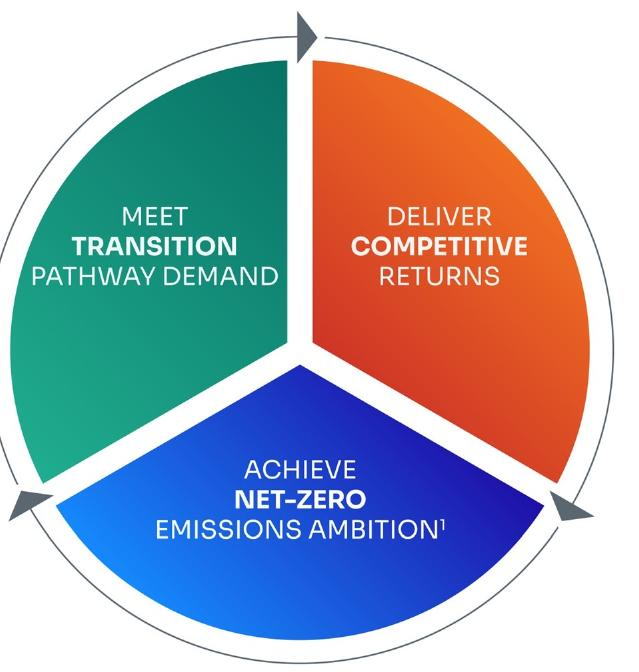
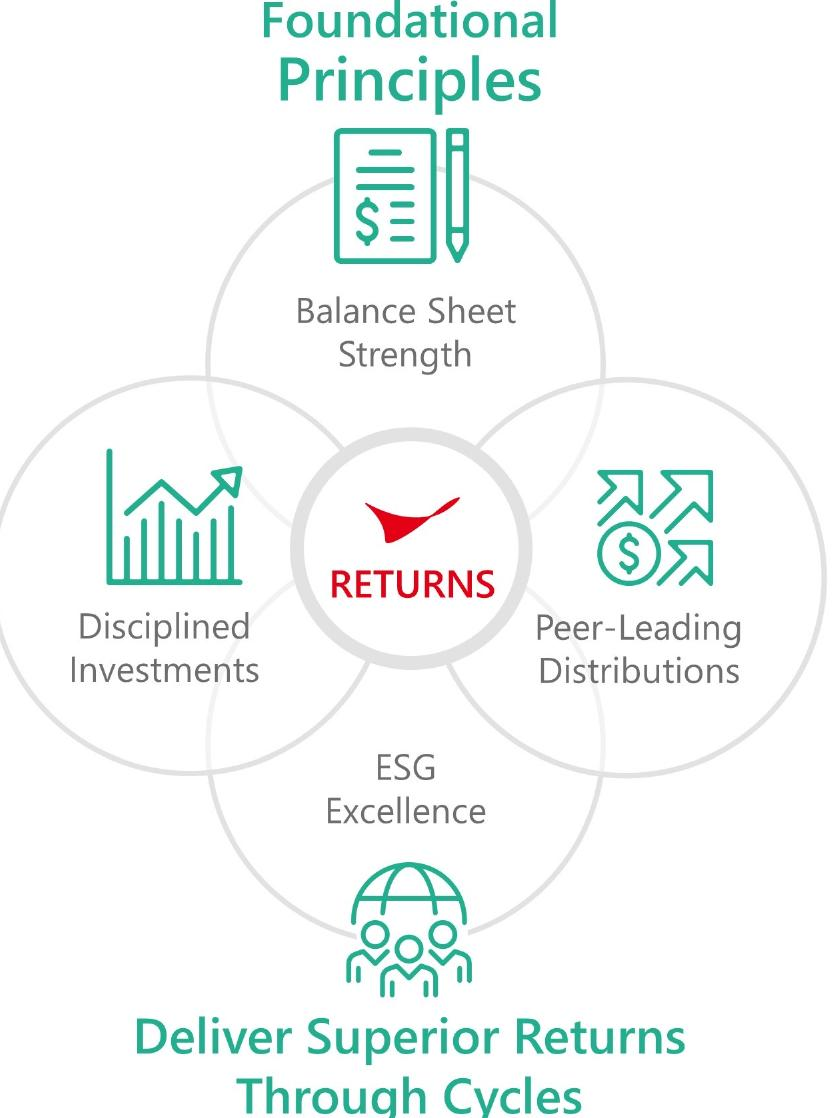
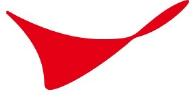
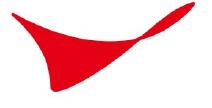
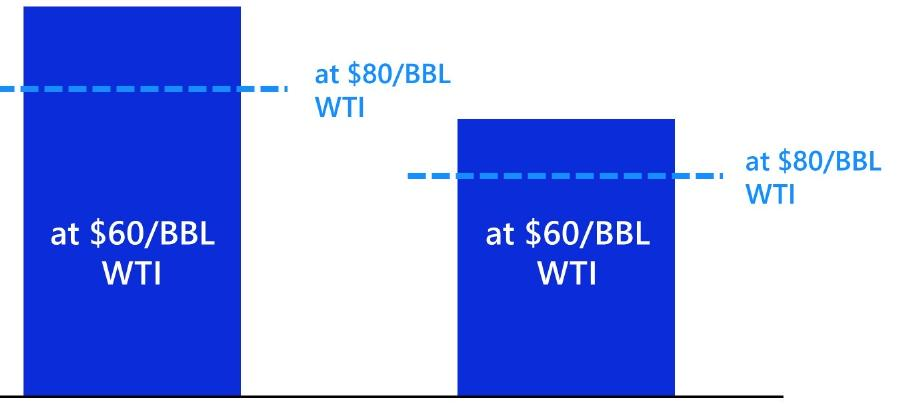
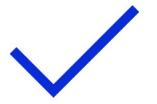
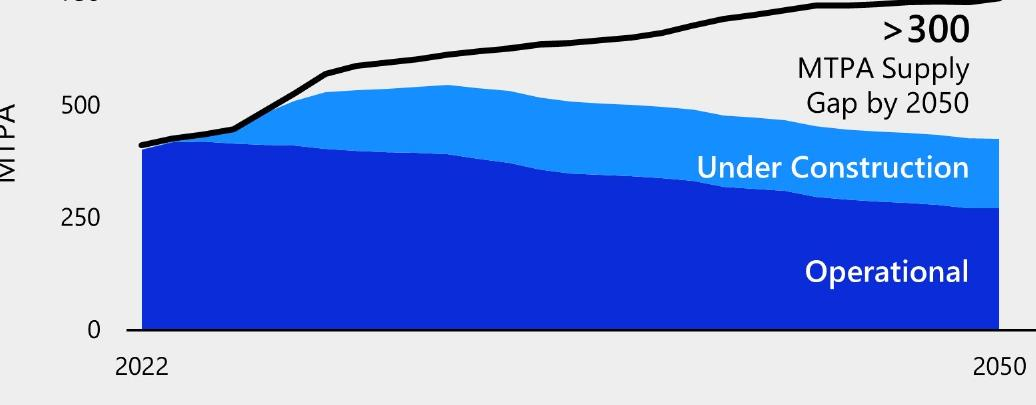
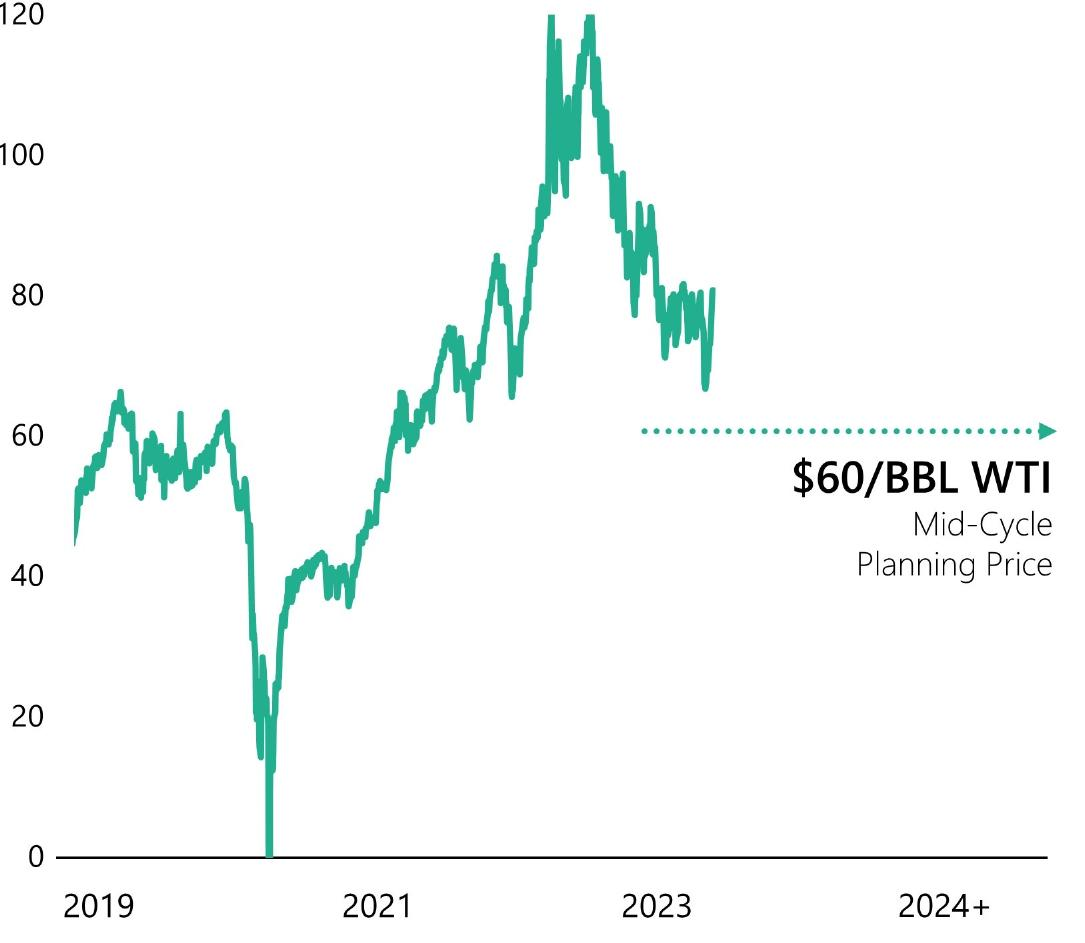
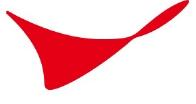
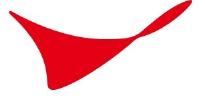
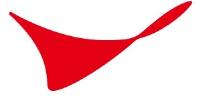
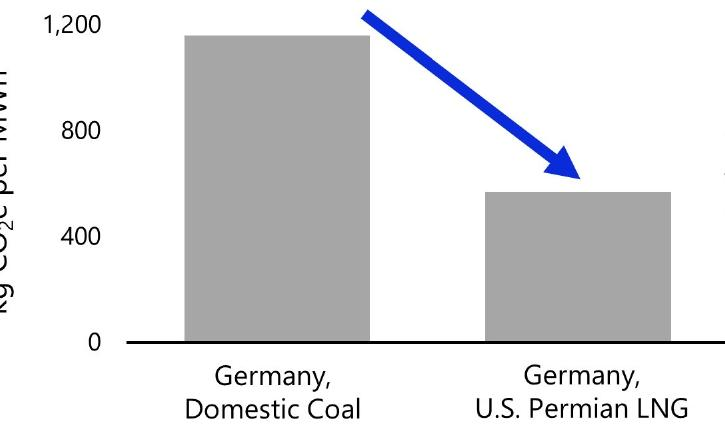
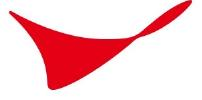
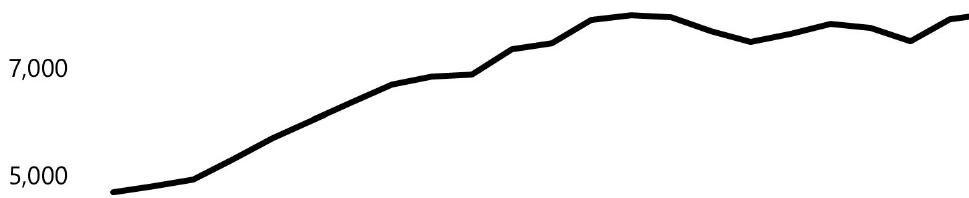

In [14]:
image_path = "backend/data/reports/2023_removed/images"
images_path = image_summarizer.get_image_path(image_path)

encoded_images = []
image_summaries = []

for image in images_path:
    encoded_image = image_summarizer.encode_image(image)
    image_summaries.append(image_summarizer.image_summarize(encoded_image))
    
    encoded_images.append(encoded_image)


In [15]:
encoded_images, image_summaries = image_summarizer.add_metadata(encoded_images, image_summaries, automatic_metadata=True)

# Store to vector database  

In [16]:
from langchain_chroma import Chroma
from langchain.storage import InMemoryStore
from langchain.schema.document import Document
from langchain_openai import OpenAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser

In [ ]:
@dataclass
class VectorDatabaseConfig:
    vectorstore_name: str
    persist_directory: str


class ConfigurationManager:
    def __init__(self, CONFIG_FILE_PATH, PARAMS_FILE_PATH):
        self.config = read_yaml(CONFIG_FILE_PATH)
        self.params = read_yaml(PARAMS_FILE_PATH)
        
    def get_vectordatabase_config(self) -> VectorDatabaseConfig:
        params = VectorDatabaseConfig(
            vectorstore_name=self.config.vector_database.vectorstore_name,
            persist_directory=self.config.vector_database.persist_directory)
        return params
    

class VectorDatabase(Extractor):
    def __init__(self, config):
        super(VectorDatabase, self).__init__()
        self.config = config
    
    def init_chromadb(self, embeddings):
        return Chroma(self.config.vectorstore_name, 
                      embeddings, 
                      persist_directory=self.config.persist_directory)
        
    def get_retriever(self, vectorstore, id_key: str="doc_id") -> MultiVectorRetriever:
        store = InMemoryStore()
        return MultiVectorRetriever(
            vectorstore=vectorstore,
            docstore=store,
            id_key=id_key
        )
          
    def generate_document(self, data, metadata=None) -> Document:
        if metadata == None:
            metadata = self.generate_unique_id(data)
        
        documents = [Document(page_content=data_, metadata=metadata_)
                        for data_, metadata_ in zip(data, metadata)]
        return documents
    
    def store_to_vb(self, data: List[Tuple], summaries: List[Document], retriever)->None:
        try:
            retriever.docstore.mset(data)
            retriever.vectorstore.add_documents(summaries)
        except Exception as e:
            print("Error in storing data to vectorbase: ", e)
            raise e


In [18]:
config_manager = ConfigurationManager(CONFIG_FILE_PATH, PARAMS_FILE_PATH)
vb_params = config_manager.get_vectordatabase_config()
print(vb_params)
vb = VectorDatabase(vb_params)
vectorstore = vb.init_chromadb(OpenAIEmbeddings())

2025-02-09 15:42:45,844 - root - INFO - Yaml read successfully from config.yaml
2025-02-09 15:42:45,847 - root - ERROR - FileNotFoundError: params.yaml
2025-02-09 15:42:46,003 - chromadb.telemetry.product.posthog - INFO - Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.


VectorDatabaseConfig(vectorstore_name='test', persist_directory='test_directory')


2025-02-09 15:42:46,139 - chromadb.config - DEBUG - Starting component System
2025-02-09 15:42:46,139 - chromadb.config - DEBUG - Starting component Posthog
2025-02-09 15:42:46,140 - chromadb.config - DEBUG - Starting component OpenTelemetryClient
2025-02-09 15:42:46,140 - chromadb.config - DEBUG - Starting component SqliteDB
2025-02-09 15:42:46,147 - chromadb.config - DEBUG - Starting component SimpleQuotaEnforcer
2025-02-09 15:42:46,147 - chromadb.config - DEBUG - Starting component SimpleRateLimitEnforcer
2025-02-09 15:42:46,148 - chromadb.config - DEBUG - Starting component LocalSegmentManager
2025-02-09 15:42:46,148 - chromadb.config - DEBUG - Starting component LocalExecutor
2025-02-09 15:42:46,148 - chromadb.config - DEBUG - Starting component SegmentAPI
2025-02-09 15:42:46,159 - chromadb.api.segment - DEBUG - Collection test already exists, returning existing collection.


In [19]:
retriever = vb.get_retriever(vectorstore, id_key="doc_id")

In [21]:
vb.store_to_vb(encoded_images, image_summaries, retriever)

2025-02-09 15:43:31,444 - openai._base_client - DEBUG - Request options: {'method': 'post', 'url': '/embeddings', 'files': None, 'post_parser': <function Embeddings.create.<locals>.parser at 0x339d8b5e0>, 'json_data': {'input': [[791, 2217, 374, 264, 4382, 6437, 4706, 389, 264, 4251, 4092, 13, 1102, 4519, 264, 31052, 323, 264, 6710, 315, 5684, 449, 264, 18160, 1879, 389, 433, 13, 578, 31052, 374, 44894, 449, 264, 5950, 315, 12706, 11, 323, 279, 5684, 706, 5238, 23377, 1495, 477, 5219, 13, 2684, 527, 912, 3230, 40099, 477, 35876, 3649, 304, 279, 2217, 13], [791, 2217, 374, 264, 42415, 3158, 9676, 94012, 279, 220, 605, 4771, 5788, 24549, 9974, 6650, 4478, 320, 34, 82256, 8, 369, 2204, 4907, 5788, 11306, 13, 578, 12414, 8183, 11105, 5788, 5990, 11, 449, 62700, 13160, 520, 220, 2636, 11, 220, 16, 11, 931, 11, 220, 16, 11, 2636, 11, 220, 17, 11, 931, 11, 323, 220, 17, 11, 2636, 8316, 382, 16, 13, 3146, 1844, 444, 44322, 320, 9230, 220, 2166, 489, 9995, 3520, 33395, 25, 720, 256, 482, 22717,

In [187]:
from base64 import b64decode
from IPython.display import display, HTML

class QueryHandler:
    def __init__(self, retriever):
        self.retriever = retriever
        self.docstore = retriever.docstore
        self.vectorstore = retriever.vectorstore
        
        
    def similarity_search(self, query: str, top_k: int=5):
        return self.retriever.vectorstore.similarity_search(query, top_k)
    
    def relevant_documents(self, query: str, top_k: int=5):
        return self.retriever.get_relevant_documents(query, k=top_k, return_metadata=True)
    
    def query_by_id(self, vectorstore_results: str):
        return self.retriever.vectorstore.get(id)
    
    def query_by_vector(self, vector: np.array, top_k: int=5):
        return self.retriever.query_by_vector(vector, top_k)
    
    def query_by_document(self, document: Document, top_k: int=5):
        return self.retriever.query_by_document(document, top_k)
        
    def map_raw_docs(self, vectorstore_results: List[Document]) -> List:
        """To map the raw documents from vectorstore results by using doc_id from metadata
        Args:
            vectorstore_results (List[Document]): results from vectorstore
        Returns:
            List: containing raw documents
        """
        raw_docs = []
        for i in vectorstore_results:
            doc_id = i.metadata["doc_id"]
            raw_docs.append(self.docstore.__dict__["store"].get(doc_id, "None"))
        return raw_docs
    
    def split_image_text_types(self, docs: List[Document]) -> Dict:
    #     ''' Split base64-encoded images and texts '''
        b64 = []
        text = []
        for doc in docs:
            if doc.metadata["type"] == "Image":
                b64.append(self.query_by_id(doc.id))
            elif doc.metadata["type"] == "Text":
                text.append(doc)

        return {
            "images": b64,
            "texts": text
        }

    @staticmethod
    def plt_img_base64(img_base64):

        # Create an HTML img tag with the base64 string as the source
        image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'

        # Display the image by rendering the HTML
        display(HTML(image_html))
        
    def plot_img_base64(self, img_base64: str):
        img = Image.open(io.BytesIO(b64decode(img_base64)))
        img.show()
        
query_handler = QueryHandler(retriever)


In [188]:
reterieved_docs = query_handler.similarity_search("what does data say about", 5)
raw_docs = query_handler.map_raw_docs(reterieved_docs)

2025-02-09 19:40:18,511 - openai._base_client - DEBUG - Request options: {'method': 'post', 'url': '/embeddings', 'files': None, 'post_parser': <function Embeddings.create.<locals>.parser at 0x33c7c54c0>, 'json_data': {'input': [[12840, 1587, 828, 2019, 922]], 'model': 'text-embedding-ada-002', 'encoding_format': 'base64'}}
2025-02-09 19:40:18,514 - openai._base_client - DEBUG - Sending HTTP Request: POST https://api.openai.com/v1/embeddings
2025-02-09 19:40:18,516 - httpcore.connection - DEBUG - close.started
2025-02-09 19:40:18,516 - httpcore.connection - DEBUG - close.complete
2025-02-09 19:40:18,516 - httpcore.connection - DEBUG - connect_tcp.started host='api.openai.com' port=443 local_address=None timeout=None socket_options=None
2025-02-09 19:40:18,536 - httpcore.connection - DEBUG - connect_tcp.complete return_value=<httpcore._backends.sync.SyncStream object at 0x33ee348e0>
2025-02-09 19:40:18,536 - httpcore.connection - DEBUG - start_tls.started ssl_context=<ssl.SSLContext obj

(5, 5)